In [0]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn import ensemble
import math

In [0]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# Load the data
train = pd.read_csv("train.csv").drop(columns=['opened_position_qty ', 'closed_position_qty'])
test = pd.read_csv("test.csv").drop(columns=['opened_position_qty ', 'closed_position_qty'])

#for i in ['last_price', 'mid', 'bid1', 'bid2', 'bid3', 'bid4', 'bid5', \
#          'ask1', 'ask2', 'ask3', 'ask4', 'ask5']:
#  train[i] = train[i] - train[i].shift(1)

train = train.drop(0)
#df = pd.concat([train,test],sort=False)


In [0]:
test

,id,last_price,mid,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,bid5,ask1,ask2,ask3,ask4,ask5,bid1vol,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol
1918,594298,5069.8,5069.1,9.0,3,5068.6,5068.2,5068.0,5067.8,5067.6,5069.6,5070.0,5070.4,5070.6,5071.6,1,2,1,4,6,3,13,9,2,3
5311,597691,5069.4,5069.3,4.0,0,5069.2,5068.8,5068.6,5068.2,5068.0,5069.4,5069.6,5070.4,5070.6,5071.6,3,1,1,2,1,1,1,9,2,3
170971,763351,5069.6,5069.3,7.0,3,5068.8,5068.6,5068.2,5068.0,5067.8,5069.8,5070.0,5070.2,5070.4,5070.6,1,1,2,1,4,2,15,1,9,2
174444,766824,5069.8,5069.4,4.0,2,5069.0,5068.6,5068.4,5068.0,5067.6,5069.8,5070.0,5070.4,5070.6,5070.8,4,1,1,4,1,2,1,2,6,2
179309,771689,5070.6,5069.5,7.0,6,5069.2,5069.0,5068.6,5068.0,5067.6,5069.8,5070.6,5070.8,5071.0,5071.4,1,3,1,3,2,1,3,2,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188422,780802,5277.4,5277.9,21.0,9,5276.8,5276.6,5276.4,5276.0,5275.6,5279.0,5279.2,5279.6,5279.8,5280.0,1,4,1,1,21,4,2,1,3,11
185615,777995,5278.6,5278.1,2.0,0,5277.8,5277.6,5277.4,5277.2,5276.8,5278.4,5278.8,5279.0,5279.2,5279.6,2,1,1,12,2,3,4,4,2,1
26322,618702,5278.8,5278.2,26.0,18,5277.4,5277.0,5276.8,5276.6,5276.4,5279.0,5279.2,5279.6,5279.8,5280.0,1,9,2,4,1,16,2,2,4,11
146184,738564,5278.4,5278.2,8.0,1,5277.8,5277.4,5277.2,5276.8,5276.6,5278.6,5278.8,5279.0,5279.2,5279.6,1,1,5,2,3,1,4,4,2,1


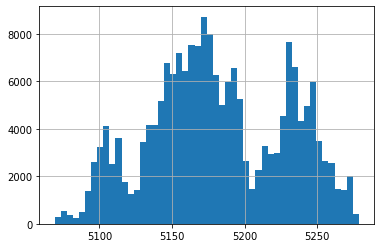

In [0]:
test['mid'].hist(bins = 50)

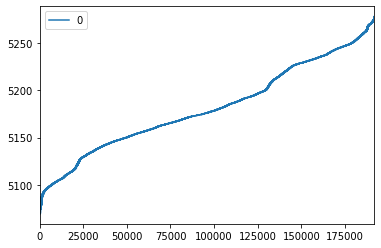

In [0]:
test = test.sort_values(by=['mid'])
i = 0
batch = int(len(test)/400)
while i < len(test):
  test[i:i + batch] = np.random.permutation(test[i:i + batch])
  i = i + batch

pd.DataFrame(test['mid'].to_numpy()).plot()

In [0]:
test = test.sort_values(by=['mid'])

for i in ['last_price', 'mid', 'bid1', 'bid2', 'bid3', 'bid4', 'bid5', \
            'ask1', 'ask2', 'ask3', 'ask4', 'ask5']:
    test[i] = test[i] - test[i].shift(1)

test = test.drop(test.index[0])

i = 0
batch = int(len(test)/40)
while i < len(test):
  test[i:i + batch] = np.random.permutation(test[i:i + batch])
  i = i + batch

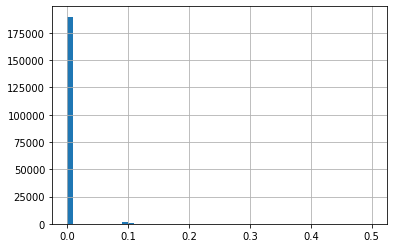

In [0]:
test['mid'].hist(bins = 50)

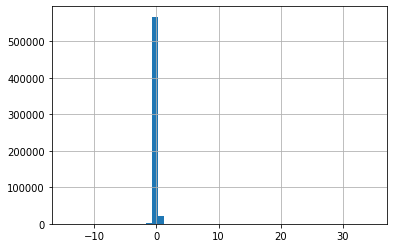

In [0]:
train['mid'].hist(bins=50)

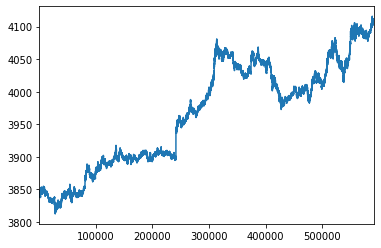

In [0]:
train['mid'].plot()

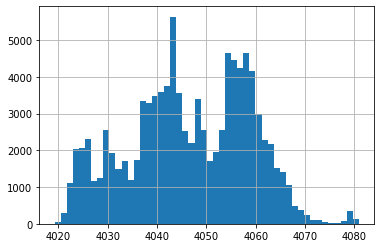

In [0]:
train['mid'][310000:410000].hist(bins=50)

In [0]:
train = df.loc[~df.y.isna()].fillna(0)
test = df.loc[df.y.isna()].drop(columns=['id', 'y'])

train_y = train.y
train_x = train.drop(columns=['id', 'y'])

In [0]:
test

,last_price,mid,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,bid5,ask1,ask2,ask3,ask4,ask5,bid1vol,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol
1,-45.4,-45.4,1.0,1,-45.4,-45.4,-45.4,-45.4,-45.4,-45.4,-45.4,-45.0,-45.0,-45.6,1,2,2,1,10,4,8,1,1,1
2,44.4,45.1,2.0,2,44.4,44.2,44.2,44.2,44.0,45.8,45.8,45.4,45.4,45.4,8,18,1,1,6,7,4,1,2,5
3,-83.8,-84.1,2.0,-1,-84.0,-83.8,-83.8,-84.2,-84.0,-84.2,-84.2,-84.2,-84.2,-84.2,8,5,4,3,1,1,1,11,6,2
4,95.6,95.3,0.0,0,95.6,95.6,95.6,96.0,96.0,95.0,95.8,95.8,95.8,95.8,1,5,1,3,3,3,2,1,3,4
5,-10.0,-9.7,3.0,2,-9.4,-9.4,-9.4,-9.4,-9.8,-10.0,-10.6,-10.2,-10.0,-10.0,1,1,1,3,1,1,1,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191854,-28.6,-27.8,0.0,0,-27.6,-27.6,-27.6,-27.4,-27.2,-28.0,-27.8,-27.8,-27.6,-27.4,1,5,3,4,2,1,3,1,3,2
191855,-28.0,-28.1,3.0,-1,-28.0,-28.0,-28.0,-28.2,-28.2,-28.2,-28.4,-28.4,-28.6,-28.8,3,1,5,1,20,16,17,4,1,16
191856,70.2,69.6,0.0,0,69.4,69.4,69.0,68.6,68.6,69.8,69.8,69.8,69.8,69.8,1,2,1,1,1,1,2,1,2,1
191857,-40.8,-40.4,6.0,2,-40.2,-40.2,-39.8,-39.2,-39.2,-40.6,-40.6,-40.6,-40.6,-40.6,4,5,6,8,37,7,1,2,1,1


In [0]:
num_folds = 10
kf = KFold(n_splits = num_folds)
r1 = linear_model.Ridge()
r2 = linear_model.Lasso()
r3 = linear_model.BayesianRidge()
r4 = linear_model.OrthogonalMatchingPursuit()
r5 = linear_model.PassiveAggressiveRegressor()
r6 = linear_model.ElasticNet()
r7 = ensemble.AdaBoostRegressor()
# er = ensemble.StackingRegressor([('ridge', r1), ('lasso', r2), ('bayes', r3), ('omp', r4), ('par', r5), ('enet', r6)])
er = ensemble.StackingRegressor([('ridge', r1), ('adaboost', r7)])
train_errors = []
test_scores = []

In [0]:
# Iterate over each fold

data = train_x.to_numpy()
labels = train_y.to_numpy()
for train_index, test_index in kf.split(data):
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # Fit the training data
    er.fit(x_train, y_train)

    print(".")
    
    # Calculate the training error for this fold
    train_prediction = er.predict(x_train)
    train_error = 0
    for i in range(y_train.size):
        train_error += ((y_train[i] - train_prediction[i]) ** 2)
        
    # Calculate the validation score for this fold
    vscore = roc_auc_score(y_test, sigmoid(er.predict(x_test)))
    print("Val score this fold: {}".format(vscore))
        
    train_errors.append(train_error / y_train.size)
    test_scores.append(vscore)

.
Val score this fold: 0.6443601171273128
.
Val score this fold: 0.6556392259055529
.
Val score this fold: 0.6560228691918747
.
Val score this fold: 0.6641219595820363
.
Val score this fold: 0.6593985087916744
.
Val score this fold: 0.6503902206815324
.
Val score this fold: 0.6550560860348237
.
Val score this fold: 0.6542918544439451
.
Val score this fold: 0.6503429191131394
.
Val score this fold: 0.6373881749097032


In [0]:
print("The average training error is {}".format(np.mean(train_errors)))
print("The average test score is {}".format(np.mean(test_scores)))
# The average test score is 0.656851095648564 with shuffling of data

test_x = test.to_numpy()
predictions = pd.DataFrame(sigmoid(er.predict(test_x)))
predictions.to_csv('submission.csv')

The average training error is 0.21449089792750295
The average test score is 0.6527011935781595
